In [1]:
import torch
import h5py
import diffusion_pde as dpde
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from omegaconf import OmegaConf
from pathlib import Path
from tqdm.notebook import tqdm

In [2]:
def init_weights(module, mode="kaiming_normal", nonlinearity="leaky_relu", zero_bias=True):
    if not isinstance(module, (torch.nn.Conv2d, torch.nn.ConvTranspose2d, torch.nn.Linear)):
        return
    if mode == "kaiming_normal":
        torch.nn.init.kaiming_normal_(module.weight, mode="fan_in", nonlinearity=nonlinearity)
    if zero_bias and module.bias is not None:
        torch.nn.init.zeros_(module.bias)   
    elif module.bias is not None:
        torch.nn.init.kaiming_normal_(module.bias, mode="fan_in", nonlinearity=nonlinearity)


# -----------------------------
# Positional / time embedding
# -----------------------------

class PositionalEmbedding(torch.nn.Module):
    def __init__(self, num_channels, max_positions=10000, endpoint=False):
        super().__init__()
        self.num_channels = num_channels
        self.max_positions = max_positions
        self.endpoint = endpoint

    def forward(self, x):
        freqs = torch.arange(start=0, end=self.num_channels//2, dtype=torch.float32, device=x.device)
        freqs = freqs / (self.num_channels // 2 - (1 if self.endpoint else 0))
        freqs = (1 / self.max_positions) ** freqs
        x = x.ger(freqs.to(x.dtype))
        x = torch.cat([x.cos(), x.sin()], dim=1)
        return x


# -----------------------------
# Residual block with embedding
# -----------------------------


def get_conv_layer(
    in_ch: int, 
    out_ch: int, 
    kernel_size: int, 
    up: bool = False,
    down: bool = False
):

    padding = max(0, (kernel_size - 1) // 2)
    if up:
        layer = torch.nn.ConvTranspose2d(in_ch, out_ch, kernel_size, stride=2, padding=padding, output_padding=1, padding_mode="zeros")
    elif down:
        layer = torch.nn.Conv2d(in_ch, out_ch, kernel_size, stride=2, padding=padding, padding_mode="reflect")
    else:
        layer = torch.nn.Conv2d(in_ch, out_ch, kernel_size, padding=padding, padding_mode="reflect")

    init_weights(layer)
    return layer


class ResBlock(torch.nn.Module):
    def __init__(
        self,
        in_ch: int,
        out_ch: int,
        emb_ch: int,
        up: bool = False,
        down: bool = False,
        dropout: float = 0.0,
        skip_scale: float = 2 ** -0.5,
    ):
        super().__init__()
        self.in_channels = in_ch
        self.out_channels = out_ch
        self.skip_scale = skip_scale
        self.up = up
        self.down = down

        # Norms
        gn1_groups = 32 if in_ch >= 32 and in_ch % 32 == 0 else in_ch
        gn2_groups = 32 if out_ch >= 32 and out_ch % 32 == 0 else out_ch
        self.norm1 = torch.nn.GroupNorm(gn1_groups, in_ch)
        self.norm2 = torch.nn.GroupNorm(gn2_groups, out_ch)

        self.act = torch.nn.SiLU()

        # Convs
        self.conv1 = get_conv_layer(in_ch, out_ch, 3, up=up, down=down)
        self.conv2 = get_conv_layer(out_ch, out_ch, 3)
        torch.nn.init.zeros_(self.conv2.weight)
        torch.nn.init.zeros_(self.conv2.bias)

        # Embedding → out_ch
        self.emb_layer = torch.nn.Linear(emb_ch, out_ch)
        init_weights(self.emb_layer)

        # Skip path
        self.skip = None
        if in_ch != out_ch or up or down:
            self.skip = get_conv_layer(in_ch, out_ch, 1, up=up, down=down)

        self.dropout = torch.nn.Dropout(dropout)


    def forward(self, x, emb):
        """
        x:   [B, C_in, H, W]
        emb: [B, emb_ch]
        """
        orig = x
        x = self.conv1(self.act(self.norm1(x)))

        # Broadcast embedding and add
        e = self.emb_layer(emb).unsqueeze(-1).unsqueeze(-1)  # [B, out_ch, 1, 1]
        x = x + e

        x = self.conv2(self.dropout(self.act(self.norm2(x))))
    
        x = x + (self.skip(orig) if self.skip is not None else orig)

        return x * self.skip_scale

# -----------------------------
# Small EDM-style UNet
# -----------------------------

class SmallEDMUNet(torch.nn.Module):
    """
    EDM-style UNet, scaled down to be < 10M params for typical choices.

    - Conditioning: concatenates obs at input (x and obs same spatial size).
    - Embedding: sigma + label combined and fed into all ResBlocks.
    """

    def __init__(
        self,
        img_channels: int,      # number of channels of x
        obs_channels: int = 0,      # number of channels of obs
        label_dim: int = 0,     # dimension of labels (0 = no labels)
        base_channels: int = 64,
        channel_mults=(1, 2, 2),   # e.g. [1,2,2] or [1,2,2,2]
        num_res_blocks: int = 2,
        dropout: float = 0.0,
        sigma_emb_dim: int = 64,
        emb_dim: int = 256,
        debug: bool = False,
    ):
        super().__init__()
        self.debug = debug
        self.img_channels = img_channels
        self.obs_channels = obs_channels
        in_channels = img_channels + obs_channels

        # --- time/noise embedding ---
        self.sigma_embed = PositionalEmbedding(sigma_emb_dim)
        init_weights(self.sigma_embed)

        self.time_mlp = torch.nn.Sequential(
            torch.nn.Linear(sigma_emb_dim, emb_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(emb_dim, emb_dim),
        )
        for m in self.time_mlp:
            init_weights(m)


        # --- label embedding (optional) ---
        if label_dim > 0:
            self.label_embed = torch.nn.Linear(label_dim, emb_dim)
            init_weights(self.label_embed)
        else:
            self.label_embed = None

        # ------------- Encoder -------------
        self.enc = torch.nn.ModuleList()
        ch = base_channels
        
        ch_list = []  # track feature dims for skip sizes
        for i, mult in enumerate(channel_mults):
            out_ch = base_channels * mult
            if i == 0:
                self.enc.append(get_conv_layer(in_channels, out_ch, 3))
            else:
                self.enc.append(ResBlock(ch, out_ch, emb_dim, down=True, dropout=dropout))
            ch = out_ch
            ch_list.append(ch)
            for _ in range(num_res_blocks):
                self.enc.append(ResBlock(ch, out_ch, emb_dim, dropout=dropout))
                ch = out_ch
                ch_list.append(ch)


        # ------------- Decoder -------------
        self.dec = torch.nn.ModuleList()
        # We'll iterate channel_mults in reverse
        for i, mult in reversed(list(enumerate(channel_mults))):
            #out_ch = base_channels * mult
            if i == len(channel_mults) - 1:
                self.dec.append(ResBlock(out_ch, out_ch, emb_dim, dropout=dropout))
                self.dec.append(ResBlock(out_ch, out_ch, emb_dim, dropout=dropout))
            else:
                self.dec.append(ResBlock(out_ch, out_ch, emb_dim, up=True, dropout=dropout))
            for _ in range(num_res_blocks + 1):  # +1 to consume skips properly
                # cat with skip features from encoder
                in_ch = out_ch + ch_list.pop()
                out_ch = base_channels * mult
                self.dec.append(ResBlock(in_ch, out_ch, emb_dim, dropout=dropout))
        
        self.final_block = torch.nn.Sequential(
            torch.nn.GroupNorm(num_channels=out_ch, num_groups=32 if (out_ch % 32) == 0 else out_ch),
            get_conv_layer(out_ch, img_channels, 3)
        )

        if self.debug:
            total_params = sum(p.numel() for p in self.parameters())
            print(f"SmallEDMUNet params: {total_params/1e6:.2f}M")

    def forward(self, x, sigma, labels=None, obs=None):
        """
        x:      [B, Cx, H, W]   (noisy state)
        obs:    [B, Co, H, W]   (initial condition / BCs)
        sigma:  [B] or [B,1]    (noise level)
        labels: [B, label_dim]  (optional)
        """
        # concat conditioning at input
        if obs is not None and self.obs_channels > 0:
            assert obs.shape[1] == self.obs_channels, f"Expected obs with {self.obs_channels} channels, got {obs.shape[1]}"
            x = torch.cat([x, obs], dim=1)

        # build embedding
        emb_sigma = self.sigma_embed(sigma)        # [B, sigma_emb_dim]
        emb = self.time_mlp(emb_sigma)             # [B, emb_dim]
        if self.label_embed is not None and labels is not None:
            emb = emb + self.label_embed(labels)   # combine as in EDM/DhariwalUNet

        skips = []
        # Encoder
        for i, block in enumerate(self.enc):
            x = block(x, emb) if isinstance(block, ResBlock) else block(x)
            skips.append(x)

        # Decoder
        for i, block in enumerate(self.dec):
            if x.shape[1] != block.in_channels:
                x = torch.cat([x, skips.pop()], dim=1)
            x = block(x, emb)

        # Final conv block
        x = self.final_block(x)
    
        return x

In [3]:
class EDMWrapper(torch.nn.Module):
    def __init__(self, 
        unet: torch.nn.Module,
        sigma_data: float = 0.5,
    ):
        super().__init__()
        self.unet = unet
        self.sigma_data = sigma_data

    def forward(self, x, sigma, *args) -> torch.Tensor:
        # x has shape (b, ch, h, w) and sigma has shape (b,)
        # both should be dtype float32 for now
        sigma = torch.reshape(sigma, (-1, 1, 1, 1))

        # weights given by the EDM paper.
        c_skip = self.sigma_data ** 2 / (sigma ** 2 + self.sigma_data ** 2)
        c_out = sigma * self.sigma_data / torch.sqrt(sigma ** 2 + self.sigma_data ** 2)
        c_in = 1 / torch.sqrt(sigma ** 2 + self.sigma_data ** 2)
        c_noise = torch.flatten(torch.log(sigma) / 4).to(torch.float32)

        F_x = self.unet(c_in * x, c_noise, *args)   # output of u-net
        D_x = c_skip * x + c_out * F_x          # denoised data

        return D_x

In [4]:
class DiffusionDataset2(torch.utils.data.Dataset):
    """
    Diffusion dataset compatible with torch DataLoader.
    Each item is a tuple (X, label) where X is the concatenation of the
    initial state and a snapshot of the trajectory at time t. the label
    is a vector containing the time t and any additional labels.
    Note that t is sampled randomly for each item from the t_steps provided.

    Parameters
    ----------
    data : torch.Tensor
        Tensor of shape (N, ch_u, h, w, T) representing the trajectories.
    t_steps : torch.Tensor
        1D tensor of shape (T,) representing the time steps corresponding to the last dimension of `data`.
    labels : Optional[torch.Tensor], optional
        Optional tensor of shape (N, label_dim) representing additional labels, by default None.
    generator : Optional[torch.Generator], optional
        Random number generator for reproducibility, by default None.
    """
    def __init__(self,
        data: np.ndarray, 
        t_steps: np.ndarray, 
        labels: np.ndarray | None = None,
        generator: torch.Generator | None = None
    ) -> None:
        super().__init__()
        # assume data is (N, ch_u, h, w, t)
        assert len(data.shape) == 5, f"Dimensions of 'data' should be (N, ch_u, h, w, t) but got {data.shape}"

        self.data = torch.from_numpy(data).float()
        self.labels = torch.from_numpy(labels).float() if labels is not None else None
        if self.labels is not None and self.labels.ndim == 1:
            self.labels = self.labels.reshape((-1, 1))  # ensure labels is (N, label_dim):
        self.t_steps = torch.from_numpy(t_steps).float()

        self.N, self.T = data.shape[0], data.shape[-1]

        self.g = generator

    def __len__(self) -> int:
        return self.N

    def __getitem__(self, idx) -> tuple[torch.Tensor, torch.Tensor]:
        
        # sample random timestep
        t0_idx = torch.randint(0, self.T-1, (1,), generator=self.g).item()
        tf_idx = torch.randint(t0_idx + 1, self.T, (1,), generator=self.g).item()

        # slice data snapshot at timestep
        # get corresponding time value
        X = self.data[idx, ..., t0_idx]  # shape (ch_u, h, w)
        Y = self.data[idx, ..., tf_idx]  # shape (ch_u, h, w)
        label = self.t_steps[tf_idx] - self.t_steps[t0_idx]  # time difference as label
        if self.labels is not None:
            label = torch.cat((torch.tensor([label]), self.labels[idx]), dim=0)
        return X, Y, label

In [5]:
class EDMLoss:
    '''
    taken from "elucidating the design space..." paper:
    https://github.com/NVlabs/edm/blob/main/training/loss.py
    '''
    def __init__(self, P_mean=-1.2, P_std=1.2, sigma_data=0.5, reduce=True, reduce_method="mean"):
        self.P_mean = P_mean
        self.P_std = P_std
        self.sigma_data = sigma_data
        self.reduce = reduce
        self.reduce_method = reduce_method

    def __call__(self, net, x, *args):
        rnd_normal = torch.randn([x.shape[0], 1, 1, 1], device=x.device)
        sigma = (rnd_normal * self.P_std + self.P_mean).exp()
        weight = (sigma ** 2 + self.sigma_data ** 2) / (sigma * self.sigma_data) ** 2
        n = torch.randn_like(x) * sigma
        D_yn = net(x + n, sigma.flatten(), *args)
        loss = weight * ((D_yn - x) ** 2)

        if not self.reduce:
            return loss

        if self.reduce_method == "mean":
            return loss.mean(dim=(1,2,3))
        elif self.reduce_method == "sum":
            return loss.sum(dim=(1,2,3))

In [6]:
data_path = Path("/home/s204790/dynamical-pde-diffusion/data/heat_logt.hdf5")

with h5py.File(data_path, "r") as f:
    data = f["U"][:]
    t_steps = f["t_steps"][:]
    labels = f["labels"][:]

In [10]:
dataset = DiffusionDataset2(data=data, t_steps=t_steps, labels=labels)
#dataset = dpde.datasets.DiffusionDataset(data=data, init_state=data[..., 0], t_steps=t_steps, labels=labels)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [7]:
net = SmallEDMUNet(
    img_channels=1,
    obs_channels=1,
    label_dim=2,
    base_channels=64,
    channel_mults=(1, 2, 2),
    num_res_blocks=2,
    dropout=0.0,
    sigma_emb_dim=64,
    emb_dim=256,
    debug=False,
)

edm = EDMWrapper(net, sigma_data=0.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
edm = edm.to(device)
print(f"Using device: {device}")
print(f"num training parameters: {sum(p.numel() for p in edm.parameters())/1e6:.2f}M")

Using device: cuda
num training parameters: 7.04M


In [12]:
epochs = 10
losses = np.zeros(epochs)
optimizer = torch.optim.Adam(edm.parameters(), lr=1e-4)
loss_fn = EDMLoss()
edm.train()
pbar = tqdm(range(epochs), desc="Training Progress")
for epoch in pbar:
    running_loss = 0.0
    for (X, Y, labels) in dataloader:
    #for X, labels in dataloader:
        X, Y, labels = X.to(device), Y.to(device), labels.to(device)
        #X, labels = X.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = loss_fn(edm, Y, labels, X).mean()
        #loss = loss_fn(edm, X, labels).mean()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses[epoch] = running_loss / len(dataloader)
    pbar.set_postfix({'Loss': losses[epoch]})

# Save the trained model
#model_path = Path("../pretrained_models/new_architecture.pth")

Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

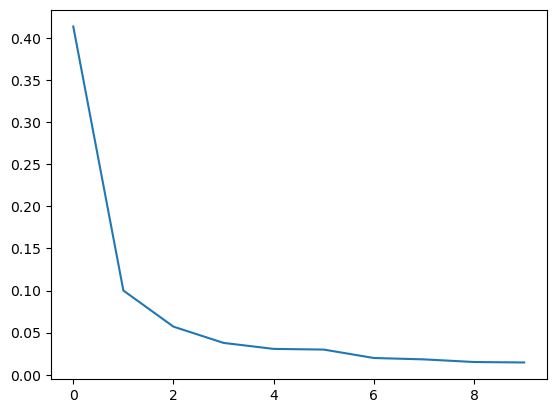

In [13]:
plt.plot(losses)

In [8]:
#torch.save(edm.state_dict(), "../pretrained_models/new_architecture.pth")
edm.load_state_dict(torch.load("../pretrained_models/new_architecture.pth", weights_only=True))

<All keys matched successfully>

In [9]:
edm.eval();

In [10]:
def X_and_dXdt_fd(net, x, sigma, labels, obs, eps=1e-5):
    lbl_p = labels.clone(); lbl_m = labels.clone()
    lbl_p[:, 0] += eps
    lbl_m[:, 0] -= eps
    up = net(x, sigma, lbl_p, obs)
    um = net(x, sigma, lbl_m, obs)
    u0 = net(x, sigma, labels, obs)
    dudt_fd = (up - um) / (2*eps)
    return u0, dudt_fd

In [26]:
def edm_sampler2(
    net,            # EDMWrapper (calls Unet inside)
    device,         # device to run the sampler on  
    sample_shape,   # (B, C, H, W) shape of samples
    loss_fn,        # loss function to compute gradients
    loss_fn_kwargs, # extra args to pass to loss function
    labels,         # (B, label_dim) extra conditioning your Unet expects; use zeros if None
    obs,            # (B, C, H, W) observation data to condition on
    zeta_u=1.0,     # weight for obs_u loss
    zeta_pde=1.0,   # weight for pde loss
    num_steps=18,
    sigma_min=0.002,
    sigma_max=80.0,
    rho=7.0,
    to_cpu=True,
    generator=None,
    return_losses=False,
):
    dtype_f = torch.float32     # net runs in fp32
    dtype_t = torch.float64     # keep time grid in fp64 for stability, as in EDM

    B = sample_shape[0]
    
    net.to(device=device)
        
    labels = labels.to(device=device, dtype=dtype_f)    # move labels to correct device and dtype
    obs = obs.to(device=device, dtype=dtype_f)          # move obs to correct device and dtype

    if generator is None:
        generator = torch.Generator(device=device)

    # Initial sample at sigma_max
    latents = torch.randn(sample_shape, device=device, generator=generator)
    
    # Move loss function kwargs to correct device and dtype
    for key, val in loss_fn_kwargs.items():
        if isinstance(val, torch.Tensor):
            loss_fn_kwargs[key] = val.to(device=device, dtype=dtype_t)

    # Discretize sigmas per EDM (Karras et al. 2022), t_N = 0 appended.
    step_idx = torch.arange(num_steps, dtype=dtype_t, device=device)
    sigmas = (sigma_max**(1.0/rho) + step_idx/(num_steps-1) * (sigma_min**(1.0/rho) - sigma_max**(1.0/rho)))**rho
    sigmas = getattr(net, "round_sigma", lambda x: x)(sigmas)
    sigmas = torch.cat([sigmas, torch.zeros_like(sigmas[:1])])  # length N+1, last = 0

    # Initialize x at sigma_0
    x_next = (latents.to(dtype_t) * sigmas[0])

    losses = torch.zeros((num_steps, 3), device=device)  # for debugging
    
    for i, (sigma_cur, sigma_next) in enumerate(zip(sigmas[:-1], sigmas[1:])):  # i = 0..N-1
        x_cur = x_next.detach().clone()
        x_cur.requires_grad = True
        # Euler step to t_next
        x_N, dxdt = X_and_dXdt_fd(net, x_cur.to(dtype_f), torch.full((B,), sigma_cur, device=device, dtype=dtype_f), labels, obs)
        x_N, dxdt = x_N.to(dtype_t), dxdt.to(dtype_t)
        d_cur = (x_cur - x_N) / sigma_cur
        x_next = x_cur + (sigma_next - sigma_cur) * d_cur

        # Heun (2nd-order) correction unless final step
        if i < num_steps - 1:
            x_N, dxdt = X_and_dXdt_fd(net, x_next.to(dtype_f), torch.full((B,), sigma_next, device=device, dtype=dtype_f), labels, obs)
            x_N, dxdt = x_N.to(dtype_t), dxdt.to(dtype_t)
            d_prime = (x_next - x_N) / sigma_next
            x_next = x_cur + (sigma_next - sigma_cur) * (0.5 * d_cur + 0.5 * d_prime)

        # Compute losses
        loss_pde, loss_obs_u = loss_fn(x_N, dxdt, **loss_fn_kwargs)

        if i <= 0.8 * num_steps:
            w_u, w_pde = zeta_u, zeta_pde
        else:
            w_u, w_pde = 0.1 * zeta_u, zeta_pde

        loss_comb = w_u * loss_obs_u + w_pde * loss_pde
        grad_x = torch.autograd.grad(loss_comb, x_cur, retain_graph=False)[0]
        x_next = x_next - grad_x
        
        losses[i] = torch.tensor([loss_obs_u.item(), loss_pde.item(), loss_comb.item()])

        del x_cur, x_N, dxdt, d_cur, grad_x, loss_pde, loss_obs_u, loss_comb
    
    # Return at sigma=0 in fp32
    x = x_next.to(dtype_f).detach()
    if to_cpu:
        x = x.cpu()

    del x_next, d_prime

    losses = losses.detach().cpu().numpy() if return_losses else None

    torch.cuda.empty_cache()
    torch.cuda.synchronize()

    return x, losses

In [27]:
def laplacian(u, dx):
    laplacian_kernel = torch.tensor(
        [[0, 1, 0],
         [1, -4, 1],
         [0, 1, 0]], dtype=u.dtype, device=u.device
    ).unsqueeze(0).unsqueeze(0)  # shape (1, 1, 3, 3)
    u_padded = torch.nn.functional.pad(u, (1, 1, 1, 1), mode='reflect')  # shape (B, C, H+2, W+2)
    laplacian_u = torch.nn.functional.conv2d(u_padded, laplacian_kernel) / (dx ** 2)  # shape (B, C, H, W)
    return laplacian_u


def heat_loss(u, dudt, obs_u, mask_u, dx, dy, labels):
    alpha = labels.view(u.shape[0], 1, 1, 1)  # Reshape to (B, 1, 1, 1) for broadcasting

    laplacian_u = laplacian(u, dx)

    loss_pde = torch.norm(dudt - alpha * laplacian_u, 2) / (u.shape[-1] * u.shape[-2])
    loss_obs_u = torch.norm(mask_u * (u - obs_u), 2)

    return loss_pde, loss_obs_u

In [28]:
val_path = Path("/home/s204790/dynamical-pde-diffusion/data/heat_lineart_validate.hdf5")
with h5py.File(val_path, "r") as f:
    val_data = f["U"][:]
    val_t_steps = f["t_steps"][:]
    val_labels = f["labels"][:]

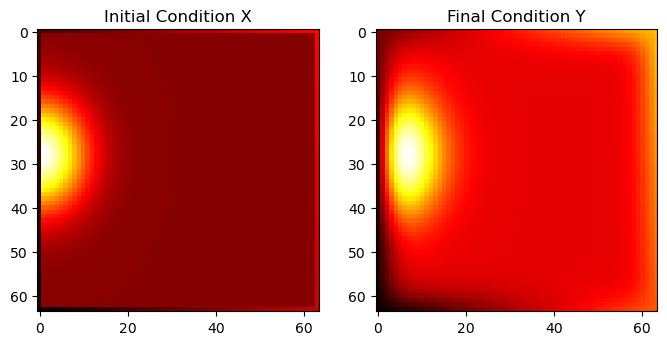

In [29]:
sample_idx = 4
t0_idx = 0
tf_idx = 3

X = val_data[sample_idx, :, :, :, t0_idx]
Y = val_data[sample_idx, :, :, :, tf_idx]
T = val_t_steps[tf_idx] - val_t_steps[t0_idx]
alpha = val_labels[sample_idx]

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(X[0], cmap='hot')
axs[0].set_title('Initial Condition X')
axs[1].imshow(Y[0], cmap='hot')
axs[1].set_title('Final Condition Y')
plt.show()

In [30]:
sample_shape = (32, 1, 64, 64)

generator = torch.Generator().manual_seed(0)

interior_u = 0.0
boundary_u = 0.2

boundary_obs_u = dpde.validation.random_boundary_mask(sample_shape[2], sample_shape[3], frac_obs=boundary_u)
interior_obs_u = dpde.validation.random_interior_mask(sample_shape[2], sample_shape[3], frac_obs=interior_u)

mask_u = dpde.validation.combine_masks(boundary_obs_u, interior_obs_u)

Final total loss: 7.0441


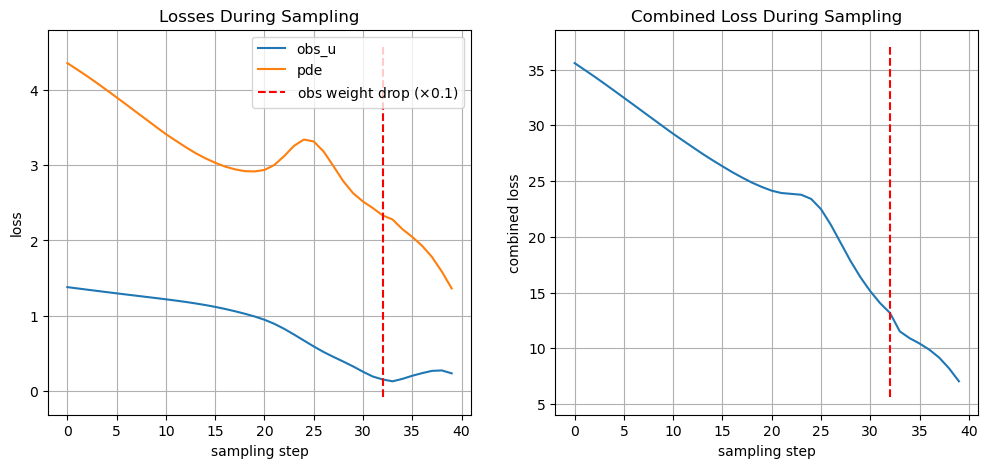

In [34]:
obs_a = torch.tensor(X).unsqueeze(0).expand(sample_shape[0], *X.shape)
obs_u = torch.tensor(Y)

dx = 1. / (X.shape[-1]-1)
ch_a = 1

zeta_u = 10.0 #5.0
zeta_pde = 5.0 #5.0

num_steps = 40

t_cond = torch.ones(sample_shape[0]) * T
alpha_cond = torch.ones_like(t_cond) * alpha.item()
labels = torch.stack([t_cond, alpha_cond], dim=-1)

loss_fn_kwargs = {
    "obs_u": obs_u,
    "mask_u": mask_u,
    "dx": dx,
    "dy": dx,
    "labels": alpha_cond,
}

torch.backends.cudnn.conv.fp32_precision = 'tf32'

#for i in range(10):
samples, losses = edm_sampler2(
    net=edm,
    device=device,
    sample_shape=sample_shape,
    loss_fn=heat_loss,
    loss_fn_kwargs=loss_fn_kwargs,
    labels=labels,
    obs=obs_a,
    zeta_u=zeta_u,
    zeta_pde=zeta_pde,
    num_steps=num_steps,
    to_cpu=True,
    return_losses=True,
)
samples = samples.numpy()
print(f"Final total loss: {losses[-1, -1]:.4f}")

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(losses[:, :2])
axs[0].set(xlabel='sampling step', ylabel='loss', title="Losses During Sampling")
axs[0].grid()
axs[1].plot(losses[:, 2])
axs[1].set(xlabel='sampling step', ylabel='combined loss', title="Combined Loss During Sampling")
axs[1].grid()
for i in range(2):
    temp_min, temp_max = axs[i].get_ylim()
    axs[i].vlines(0.8 * num_steps, ymin=temp_min, ymax=temp_max, color='red', linestyle='--')
axs[0].legend(['obs_u', 'pde', 'obs weight drop ($\\times 0.1$)'])
plt.show()

In [35]:
mean = np.mean(samples, axis=0).squeeze()

mse = np.mean((samples - Y[np.newaxis, ...])**2, axis=0).squeeze()

-0.21332932 0.5939438


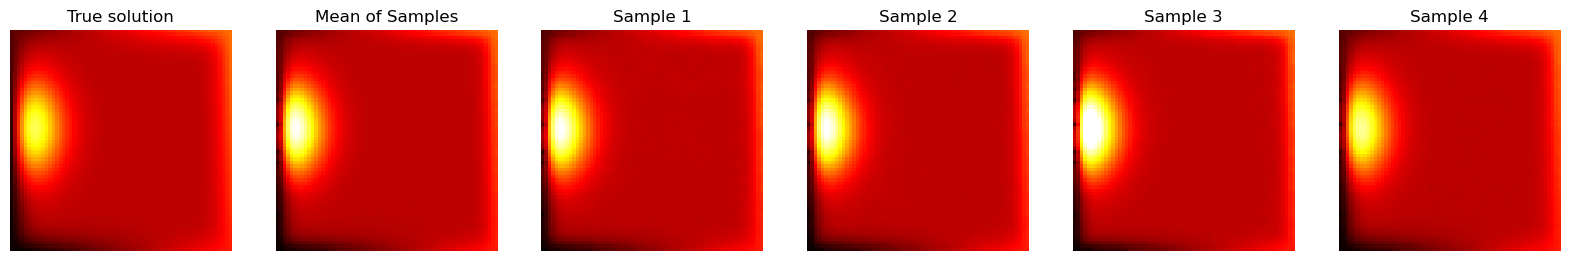

In [37]:
vmin, vmax = min(np.min(mean), np.min(mse)), max(np.max(mean), np.max(mse))
print(vmin, vmax)
fig, axs = plt.subplots(1, 6, figsize=(20, 5))
axs[0].imshow(Y[0], cmap='hot', vmin=vmin, vmax=vmax)
axs[0].set(title="True solution")
axs[1].imshow(mean, cmap='hot', vmin=vmin, vmax=vmax)
axs[1].set(title="Mean of Samples")
for i in range(4):
    axs[i+2].imshow(samples[i, 0], cmap='hot', vmin=vmin, vmax=vmax)
    axs[i+2].set(title=f"Sample {i+1}")
for ax in axs.flat:
    ax.axis('off')
plt.show()

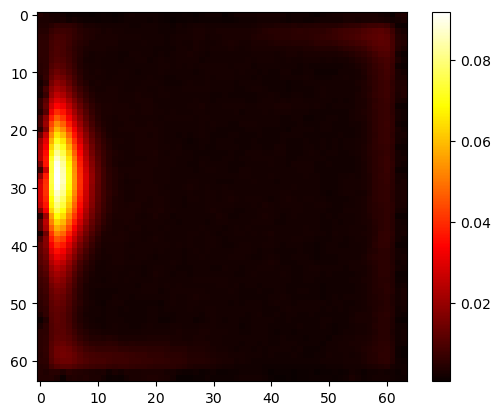

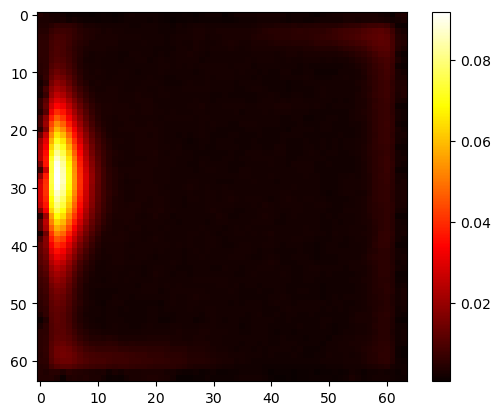

In [ ]:
plt.imshow(np.std(samples, axis=0).squeeze(), cmap='hot')
plt.colorbar()
plt.show()